In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import sys, os
sys.path.append('..')

## ひらがなデータセット

[[239 239 240 ... 235 235 236]
 [239 239 240 ... 235 235 236]
 [238 238 240 ... 235 235 236]
 ...
 [241 241 242 ... 241 241 242]
 [241 241 242 ... 241 241 242]
 [241 241 242 ... 241 241 242]]


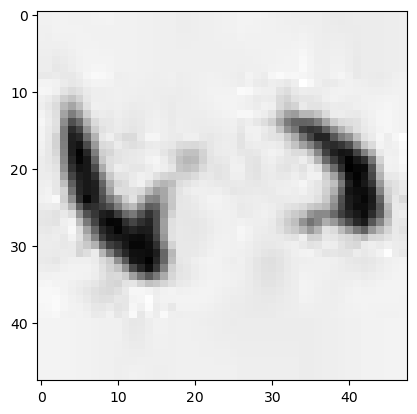

In [585]:
# hiragana
# https://github.com/ndl-lab/hiragana_mojigazo
DATADIR = "../data/hiragana73"
CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

category = CATEGORIES[1] # 0: あ, 1: い
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[0]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

## 現状

In [2]:
class Conv2Central(nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel  = Variable(torch.tensor([[[[1., 0.5],[0.5, 0.25]]]]))
    
    def forward(self, img):
        N, H, W = img.size()
        img0 = img.unsqueeze(1)
        
        img1 = torch.cat((torch.cat((img0, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img2 = F.conv2d(img1, self.kernel, stride=(1, 1))
        img3 = torch.flip(img2, dims=[0])
        
        img4 = torch.cat((torch.cat((img3, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img5 = F.conv2d(img4, self.kernel, stride=(1, 1))
        img6 = torch.flip(img5, dims=[1])
        
        img7 = torch.cat((torch.cat((img6, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img8 = F.conv2d(img7, self.kernel, stride=(1, 1))
        img9 = torch.flip(img8, dims=[0])
        
        img10 = torch.cat((torch.cat((img9, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img11 = F.conv2d(img10, self.kernel, stride=(1, 1))
        img12 = torch.flip(img11, dims=[1])
        
        img13 = img12.squeeze(1)
        return img13

In [3]:
class RoundNoGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.round()
    @staticmethod
    def backward(ctx, g):
        return g

In [4]:
class PlotLine(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        #self.conv2central = Conv2Central()
#         self.num2point = Num2Point(img_size)
#         self.num2point.load_state_dict(torch.load('params.pth', map_location=torch.device('cpu') ))
#         # freeze all layers
#         for param in self.num2point.parameters():
#             param.requires_grad = False
        self.cs = torch.tensor(range(0, img_size)).to(torch.float).unsqueeze(0)
    
    def forward(self, points):
        N = points.size()[0] # batch_size
        
        points0 = torch.cat((torch.zeros([N,1,2]),
                            points.repeat([1,1,2]).reshape([N,-1, 2]),
                            torch.zeros([N,1,2])), dim=1).reshape([N, -1, 2, 2])[:, 1:-1]
        #print(points0)
        t = torch.tensor(range(0, self.img_size+1))/self.img_size
        ts = torch.stack((1-t, t)).to(torch.float)
        line = torch.matmul(ts.mT, points0)
        #print(line)
        #line = torch.round(line)
        line0 = RoundNoGradient.apply(line)
        #line0 = line
        #print(line0)
        line1 = line0[:, :, 0:-1].reshape(N, -1, 2)
        #print(line1)
        shape = line1.size()
        line2 = line1.flatten()
        #line4 = F.softmax(self.num2point(line2), dim=1)
        line4 = torch.exp(-(line2.reshape(N, -1, 1) - self.cs)**2)
        #print(line4)
        line5 = line4.reshape(*shape, -1)
        x = line5[:, :, 0, :].unsqueeze(2)
        y = line5[:, :, 1, :].unsqueeze(2)
        p_map = torch.matmul(x.mT, y).sum(dim=1)
        #p_map0 = self.conv2central(p_map)
        p_map0 = torch.tanh(p_map)
        #p_map0 = p_map
        return p_map0

In [5]:
def process_img(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 1, cv2.THRESH_OTSU)
#     kernel = np.ones((5,5),np.float32)/25.
#     img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    # img_blr = img_blr.squeeze()
    return img_th

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img):
        super().__init__()
        self.img_size = len(img)
        self.img = torch.from_numpy(process_img(img)).clone().unsqueeze(0)
        
        self.plot_line = PlotLine(self.img_size)
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        self.p_map = None
        
    def forward(self, points):
        alpha = 0.06 #0.06
        beta = 1.75 #1.00
        distance = (torch.diff(points, dim=-2)**2).sum()
        step_distances = (torch.diff(points, dim=-2)**2).sum(dim=-1)
        step_mean = step_distances.mean()
#         var = points.var(dim=-2).sum()
        var = points.std(dim=-2).sum()
#         var = torch.log(points.var(dim=-2).sum())
#         var = 1.
        eps = 1e-5
        const = distance/(var + eps)
        
        x = self.plot_line(points)
        self.p_map = x
        t = self.img
        #loss = torch.sum(x*self.img)
        #loss = self.criterion(x, self.img)
        #loss = ((x - t)**2).sum() + distance
        #loss = ((x - t)**2).sum() + const
        loss = (beta*((x - t)**2).sum() + alpha*distance)/(var + eps)
#         loss = (beta*((x - t)**2).sum())/(var + eps) + alpha*distance
        return loss


In [7]:
class Generator(nn.Module):
    def __init__(self, img_size, n_point):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 2*n_point
        hidden_size1 = img_size*output_size
        hidden_size2 = n_point**2
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=False)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img):
        x = self.flatten(img)
        #x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする. --> x = nn.Flatten(img)
        x = self.sigmoid(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.sigmoid(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        y_num = torch.sigmoid(y)*float(self.img_size - 1.0)
        out = y_num.reshape(-1, self.n_point, 2)
        return out

In [8]:
def zscore(x, axis = None):
    x_mean = x.mean(axis=axis, keepdims=True)
    x_std  = np.std(x, axis=axis, keepdims=True)
    z_score = (x-x_mean)/x_std
    return z_score

def make_input(img):
    img = np.array(img)
    img = ~img
    img = zscore(img)
    return torch.from_numpy(img).to(torch.float)

In [9]:
def train_gen(img, n_point=20, iteration = 2000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')
    
    img_size = len(img)
    
    gen = Generator(img_size, n_point).to(device)
    disc = Discriminator(img).to(device)
    
    optimizer=optim.SGD(gen.parameters(), lr=0.001)
    
    points_log = []
    losses = []

    inputs = make_input(img).unsqueeze(0)
    inputs = inputs.to(device)

    gen = gen.train()

    for i in range(0, iteration):
        points = gen(inputs)
        
        loss = disc(points)
        
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
    
        if i%100 == 0:
            print(f'iter: {i}, loss: {loss}')
            points_log.append(points.cpu())
            losses.append(loss.cpu())
            
    return points_log, losses

## 改善

In [156]:
class PlotLine2(nn.Module):
    # 太さも操作可能にする
    # input: [N, points_num, 3]
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.cmp_num = int(img_size*np.sqrt(2))
        self.co = torch.tensor(range(0, img_size)).to(torch.float).unsqueeze(0) # 座標ベクトル
        t = torch.tensor(range(0, self.cmp_num+1))/self.cmp_num
        self.ts = torch.stack((1-t, t)).to(torch.float) # 補完ベクトル
    
    def forward(self, points):
        N = points.size()[0] # batch_size
        
        point_pairs = torch.cat((torch.zeros([N,1,3]),
                                 points.repeat([1,1,2]).reshape([N,-1,3]),
                                 torch.zeros([N,1,3])),dim=1).reshape([N, -1, 2, 3])[:, 1:-1]
        
        segs_points = torch.matmul(self.ts.mT, point_pairs)
        
        line_points = segs_points[:, :, 0:-1].reshape(N, -1, 3)
        
        shape = line_points.size()
        # print(shape)
        xy = line_points[:,:,:2]
        xy_shape = xy.size()
        # print(xy_shape)
        w = line_points[:,:,2].unsqueeze(-1).unsqueeze(-1)
        # print(w.size())
        
        xy_ver = xy.reshape(N, -1, 1)

        plot_xy = torch.exp((-(xy_ver - self.co)**2).reshape(*xy_shape, -1)/(2*w))
        # print(plot_xy.size())

        x = plot_xy[:, :, 0, :].unsqueeze(2)
        y = plot_xy[:, :, 1, :].unsqueeze(2)

        draft = torch.matmul(x.mT, y).sum(dim=1)
        line = torch.tanh(draft)
        return line

In [157]:
plot2 = PlotLine2(48)

<AxesSubplot: >

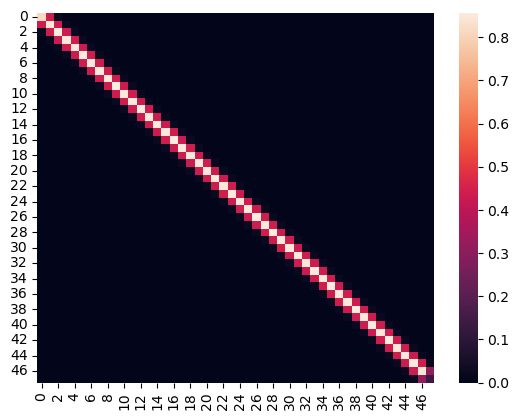

In [849]:
points0 = torch.tensor([[[ 0,  0, 0.25],
                         [47, 47, 0.25]]])

line0 = plot2(points0)
sns.heatmap(line0.detach().numpy()[0])

In [851]:
line0.max()

tensor(0.8565)

<AxesSubplot: >

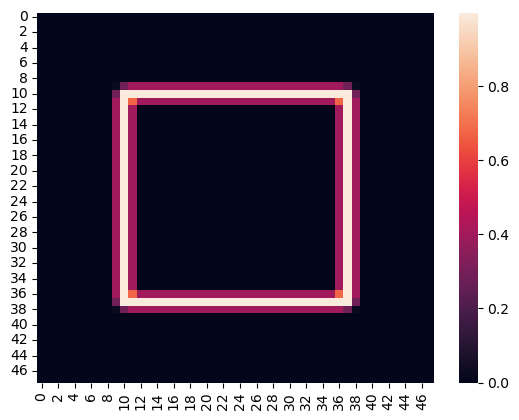

In [159]:
points1 = torch.tensor([[[10, 10, 0.25],
                         [37, 10, 0.25],
                         [37, 37, 0.25],
                         [10, 37, 0.25],
                         [10, 10, 0.25]]])
# points1 = torch.tensor([[[1, 1, 0.25],
#                          [46,46,0.25]]])
line1 = plot2(points1)
sns.heatmap(line1.detach().numpy()[0])

<AxesSubplot: >

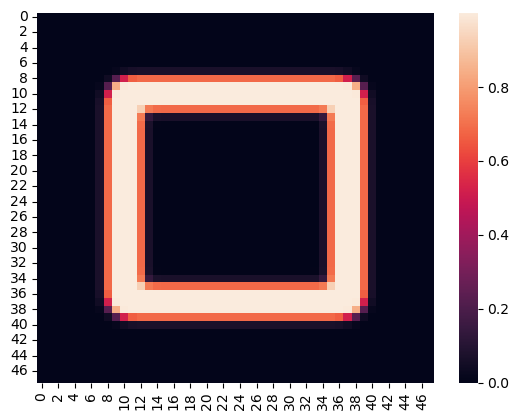

In [160]:
points2 = torch.tensor([[[10, 10, 1.],
                         [37, 10, 1.],
                         [37, 37, 1.],
                         [10, 37, 1.],
                         [10, 10, 1.]]])
line2 = plot2(points2)
sns.heatmap(line2.detach().numpy()[0])

<AxesSubplot: >

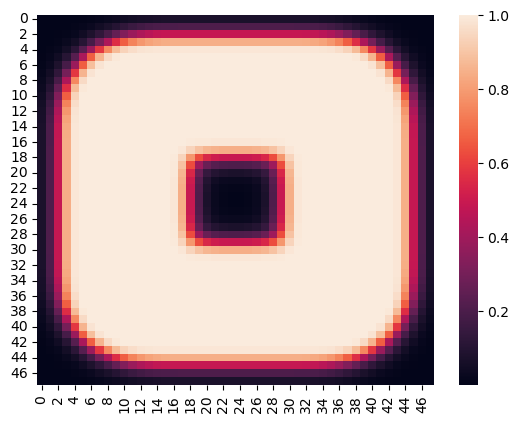

In [839]:
points3 = torch.tensor([[[10, 10, 9.],
                         [37, 10, 9.],
                         [37, 37, 9.],
                         [10, 37, 9.],
                         [10, 10, 9.]]])
line3 = plot2(points3)
sns.heatmap(line3.detach().numpy()[0])

In [162]:
print(line1.max())
print(line2.max())
print(line3.max())

tensor(0.9969)
tensor(1.0000)
tensor(1.)


In [168]:
points = torch.randint(0, 48, [5, 3]).to(torch.float)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
line = plot2(inputs)
loss = line.sum()
loss

tensor(1787.7777, grad_fn=<SumBackward0>)

In [169]:
loss.backward()

In [172]:
inputs.grad

tensor([[[ -4.8202,   3.6376,   6.0792],
         [-13.2579,  -9.8039,   9.2038],
         [  3.0883,   3.2683,   4.2263],
         [  7.4459,   4.9676,   3.5963],
         [  0.1198,   0.1215,   0.1244]]])

In [822]:
class Discriminator2(nn.Module):
    def __init__(self, img):
        super().__init__()
        self.img_size = len(img)
        self.img = torch.from_numpy(process_img(img)).clone().unsqueeze(0)
        
        self.plot_line = PlotLine2(self.img_size)
        self.p_map = None
        self.error_log = []
        self.distance_log = []
        self.distribution_log = []
        
    def forward(self, points):
        # alpha = 50.
        # beta = 2.0
        # gamma = 0.01
        # alpha = 50 #10.
        # beta = 10
        # gamma = 1.0 #1.0
        alpha = 1.0 #10.
        beta = 1.0
        gamma = 1.0 #1.0
        
        eps = 1e-6

        # distance = (torch.sqrt((torch.diff(points[:,:,0:2], dim=-2)**2).sum(dim=-1) + eps)).sum()
        # distance = (torch.diff(points[:,:,0:2], dim=-2)**2).sum()
        distance = torch.abs(torch.diff(points[:,:,0:2], dim=-2)).sum()
        var = points[:,:,0:2].std(dim=-2).sum()
        
        x = self.plot_line(points)
        t = self.img


        error = ((x - t)**2).sum()

        #loss = error
        #loss = alpha*error + beta*distance - gamma*var
        loss = (alpha*error + beta*distance)/(gamma*var)
        #loss = (error*distance)/var
        #loss = (alpha*((x - t)**2).sum() + beta*distance)/(var + eps)
        #loss = alpha*((x - t)**2).sum() + beta*(distance/(var + eps))
        #loss = (beta*((x - t)**2).sum())/(var + eps) + alpha*distance
        self.p_map = x
        self.error_log.append(error.detach().numpy())
        self.distance_log.append(distance.detach().numpy())
        self.distribution_log.append(var.detach().numpy())
        return loss

In [693]:
class Generator2(nn.Module):
    # 太さ対応生成器
    def __init__(self, img_size, n_point, w_m=0.25, w_M=4.):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 3*n_point
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2)

        conved = (img_size - 4)//2
        conved = (conved - 4)//2
        hidden_size1 = 3*conved**2
        print(hidden_size1)
        
        hidden_size2 = 3*((conved**2 + output_size)//2)
        print(hidden_size2)

        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc2 = nn.Linear(hidden_size2, output_size, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.p_scale = float(img_size - 1)
        self.w_M = w_M
        self.w_m = w_m
        self.w_scale = w_M - w_m
        self.scale_W = torch.tensor([[[self.p_scale, self.p_scale, self.w_scale]]])
        self.scale_b = torch.tensor([[[0., 0., w_m]]])
        
    def forward(self, data):
        x = self.relu(self.conv1(data)) # conv1 -> relu
        x = self.pool(x) # pool
        x = self.relu(self.conv2(x)) # conv2 -> relu
        x = self.pool(x) # pool
        x = x.view(x.size(0), -1) # reshape to use linear function
        x = self.sigmoid(self.fc1(x)) # fc1 -> sigmoid
        y = self.sigmoid(self.fc2(x)) # fc1 -> sigmoid
        raw = y.reshape(-1, self.n_point, 3)
        out = raw*self.scale_W + self.scale_b
        return out

In [694]:
gen2 = Generator2(48, 5)

243
144


In [695]:
N = 1
img_size = 48
imgs = np.random.randint(0, 2, [N, 1, img_size, img_size])
ax = np.array(range(0, img_size))
X, Y = np.meshgrid(ax, ax)
Xs = np.tile(X, (N, 1)).reshape(N, 1, img_size, img_size)
Ys = np.tile(Y, (N, 1)).reshape(N, 1, img_size, img_size)
data = np.concatenate([Xs, Ys, imgs], 1)
inputs = Variable(torch.from_numpy(data.astype(np.float32)).clone(), requires_grad=True)
points = gen2(inputs)
loss = points.sum()
loss

tensor(232.3347, grad_fn=<SumBackward0>)

In [696]:
points

tensor([[[23.1239, 22.4730,  2.1158],
         [21.9877, 20.8706,  2.0122],
         [23.1104, 18.5019,  2.2748],
         [21.5171, 22.7768,  2.0065],
         [26.0131, 21.5586,  1.9923]]], grad_fn=<AddBackward0>)

In [228]:
def make_input2(imgs):
    if len(imgs.shape) > 2:
        N, img_size, _ = imgs.shape
    else:
        N = 1
        img_size, _ = imgs.shape
    imgs = imgs.reshape(N, 1, img_size, img_size)
    ax = np.array(range(0, img_size))
    X, Y = np.meshgrid(ax, ax)
    Xs = np.tile(X, (N, 1)).reshape(N, 1, img_size, img_size)
    Ys = np.tile(Y, (N, 1)).reshape(N, 1, img_size, img_size)
    data = np.concatenate([Xs, Ys, imgs], 1)
    return data

In [281]:
data = make_input2(process_img(img_array))
data.shape

(1, 3, 48, 48)

<AxesSubplot: >

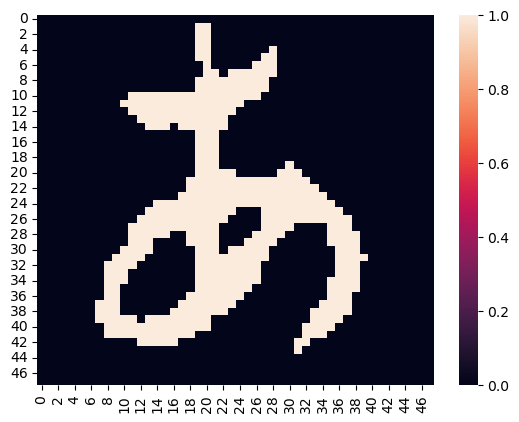

In [282]:
sns.heatmap(data[0, 2])

In [641]:
def train_gen2(img, n_point=20, iteration = 1000, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')
    
    img_size = len(img)
    
    gen2 = Generator2(img_size, n_point).to(device)
    disc2 = Discriminator2(img).to(device)
    
    #optimizer=optim.Adam(gen2.parameters(), lr=lr)
    #optimizer=optim.AdamW(gen2.parameters(), lr=lr)
    #optimizer=optim.SGD(gen2.parameters(), lr=lr)
    #optimizer=optim.RMSprop(gen2.parameters(), lr=lr)
    #optimizer=optim.Adagrad(gen2.parameters(), lr=lr)
    optimizer=optim.Adadelta(gen2.parameters(), lr=lr)
    
    points_log = []
    plot_log = []
    losses = []

    inputs = make_input2(process_img(img))
    inputs = torch.from_numpy(inputs.astype(np.float32)).clone().to(device)

    gen2 = gen2.train()

    for i in range(0, iteration):
        points = gen2(inputs)
        
        loss = disc2(points)
        
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
    
        if i%100 == 0:
            print(f'iter: {i}, loss: {loss}')
            points_log.append(points)
            plot_log.append(disc2.p_map.cpu())
            losses.append(loss.cpu().detach().numpy())
    
    errors = disc2.error_log
    distances = disc2.distance_log
    distributions = disc2.distribution_log
            
    return points_log, plot_log, losses, errors, distances, distributions

[[236 236 236 ... 238 238 238]
 [236 236 236 ... 239 239 239]
 [237 237 237 ... 239 239 239]
 ...
 [241 243 243 ... 237 237 237]
 [237 239 242 ... 237 237 236]
 [238 239 241 ... 237 236 236]]


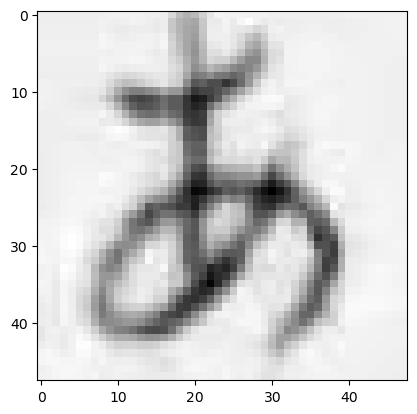

In [812]:
category = CATEGORIES[0] # 0: あ, 1: い
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[9]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

In [833]:
# points_log, plot_log, losses, errors, distances, distribution = train_gen2(img_array, n_point=16, iteration=2000, lr=0.001)
points_log, plot_log, losses, errors, distances, distribution = train_gen2(img_array, n_point=16, iteration=2000, lr=0.005)

using: cpu
243
192
iter: 0, loss: 89.59329986572266
iter: 100, loss: 39.29639434814453
iter: 200, loss: 26.823701858520508
iter: 300, loss: 20.58287239074707
iter: 400, loss: 17.42573356628418
iter: 500, loss: 16.095478057861328
iter: 600, loss: 15.119959831237793
iter: 700, loss: 14.43748950958252
iter: 800, loss: 13.966063499450684
iter: 900, loss: 13.883832931518555
iter: 1000, loss: 13.8331937789917
iter: 1100, loss: 13.803786277770996
iter: 1200, loss: 13.76262378692627
iter: 1300, loss: 13.715559005737305
iter: 1400, loss: 13.68584156036377
iter: 1500, loss: 13.677546501159668
iter: 1600, loss: 13.645800590515137
iter: 1700, loss: 13.630637168884277
iter: 1800, loss: 13.5419282913208
iter: 1900, loss: 13.448616981506348


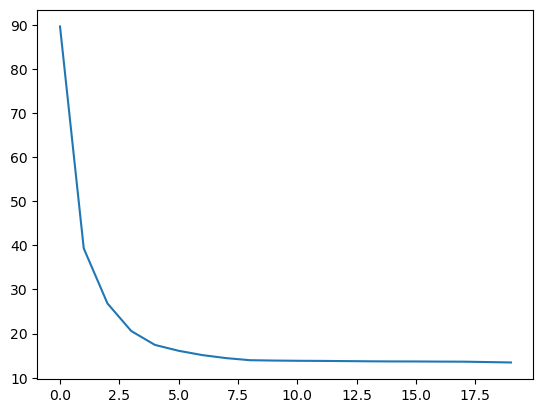

In [834]:
plt.plot(losses)

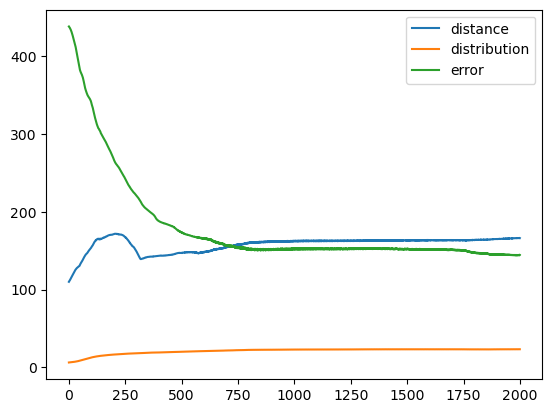

In [835]:
plt.plot(distances, label="distance")
plt.plot(distribution, label="distribution")
plt.plot(errors, label="error")
plt.legend()
plt.show()

<AxesSubplot: >

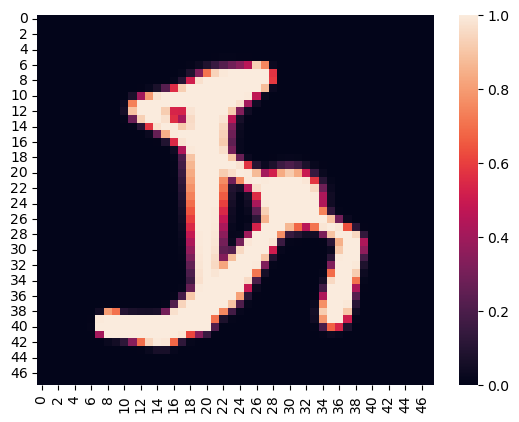

In [836]:
sns.heatmap(plot_log[-1].detach().numpy()[0])

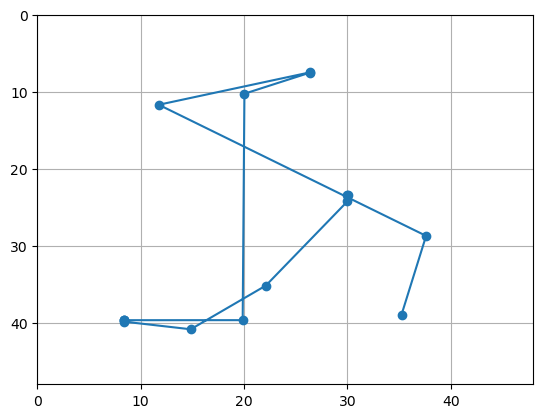

In [837]:
pos = points_log[-1].detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(pos[:, 1], pos[:, 0], marker='o')
plt.show()

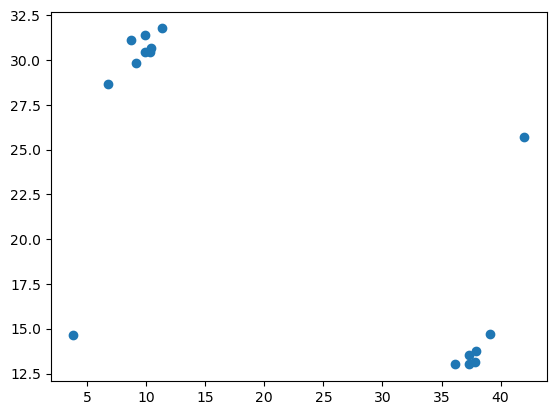

In [775]:
plt.scatter(pos[:,1], pos[:,0])

In [349]:
points_log[-1].detach().numpy()[0, :, 2]

array([0.43692607, 0.25026235, 0.47560477, 0.53073037, 0.40144616,
       3.9494007 , 2.5959399 , 0.50897545, 0.5331069 , 0.2939081 ,
       0.674044  , 1.1649507 , 0.25021094, 0.25006607, 0.4573801 ,
       0.45244423, 0.2811371 , 1.1617357 , 0.38779518, 0.2559524 ],
      dtype=float32)